# BII benchmark models

In [1]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

In [3]:
import pymc as pm
import numpy as np
import polars as pl
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union

In [6]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [4]:
import jax
from jax import devices

print(jax.devices())
print(jax.local_device_count())
# gpu_device = jax.devices("METAL")[0]
# cpu_device = jax.devices("cpu")[0]
# print(gpu_device)
# print(cpu_device)

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]
10


In [5]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="arviz")

In [6]:
plt.rcParams["grid.color"] = "grey"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.axisbelow"] = True

## Load training data

In [7]:
# Load model data
df = pl.read_parquet("../../data/runs/run_folder_2024-04-16_18.14/model_data.parquet")

In [8]:
df.head()

shape: (5, 52)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ SS        ┆ SSB       ┆ SSBS      ┆ Biome     ┆ … ┆ Cropland_ ┆ Pasture_M ┆ Pasture_L ┆ Urban_Al │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ Light_Int ┆ inimal    ┆ ight_Inte ┆ l uses x │
│ str       ┆ str       ┆ str       ┆ str       ┆   ┆ ense x    ┆ use x Roa ┆ nse x     ┆ Road_den │
│           ┆           ┆           ┆           ┆   ┆ Road_de…  ┆ d_densi…  ┆ Road_den… ┆ sity_50… │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AD1_2009_ ┆ AD1_2009_ ┆ AD1_2009_ ┆ Tropical  ┆ … ┆ -0.0      ┆ -0.0      ┆ -0.0      ┆ -0.0     │
│ _Vergara  ┆ _Vergara  ┆ _Vergara  ┆ & Subtrop ┆   ┆           ┆           ┆           ┆          │
│ 1         ┆ 1         ┆ 1  3      ┆ ical      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Moist     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Bro…      ┆   ┆           ┆           ┆           ┆          │
│ AD1_2013_ ┆ AD1_2013_ ┆ AD1_2013_ ┆ Tropical  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ _Grass 1  ┆ _Grass 1  ┆ _Grass 1  ┆ & Subtrop ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 1         ┆ ical      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Moist     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Bro…      ┆   ┆           ┆           ┆           ┆          │
│ AD1_2013_ ┆ AD1_2013_ ┆ AD1_2013_ ┆ Tropical  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ _Grass 2  ┆ _Grass 2  ┆ _Grass 2  ┆ & Subtrop ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ 10        ┆ ical      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Moist     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Bro…      ┆   ┆           ┆           ┆           ┆          │
│ AR1_2008_ ┆ AR1_2008_ ┆ AR1_2008_ ┆ Tropical  ┆ … ┆ -0.0      ┆ -0.0      ┆ -0.0      ┆ -0.61594 │
│ _Johnson  ┆ _Johnson  ┆ _Johnson  ┆ & Subtrop ┆   ┆           ┆           ┆           ┆ 3        │
│ 1         ┆ 1         ┆ 1  5      ┆ ical Dry  ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Broad…    ┆   ┆           ┆           ┆           ┆          │
│ AR1_2008_ ┆ AR1_2008_ ┆ AR1_2008_ ┆ Tropical  ┆ … ┆ -0.0      ┆ -0.0      ┆ -0.0      ┆ -0.0     │
│ _Navarret ┆ _Navarret ┆ _Navarret ┆ & Subtrop ┆   ┆           ┆           ┆           ┆          │
│ e 1       ┆ e 1       ┆ e 1  26   ┆ ical      ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Moist     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Bro…      ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## Generic functions

In [9]:
def transform_response_variable(df: pl.DataFrame, method: str) -> pl.DataFrame:

    adjust = 0.001
    original_col_name = "Max_scaled_abundance"
    transformed_col_name = original_col_name

    # Small adjustment to align with support for Beta distribution
    if method == "adjust" or method == "logit":
        df = df.with_columns(
            pl.when(pl.col(original_col_name) == 0)
            .then(adjust)
            .when(pl.col(original_col_name) == 1)
            .then(1 - adjust)
            .otherwise(pl.col(original_col_name))
            .alias(original_col_name)
        )
        if method == "logit":
            transformed_col_name += "_logit"
            df = df.with_columns(
                pl.col(original_col_name)
                .map_elements(lambda x: logit(x))
                .alias(transformed_col_name)
            )

    # Square root transformation
    elif method == "sqrt":
        transformed_col_name += "_sqrt"
        df = df.with_columns(
            pl.col(original_col_name).sqrt().alias(transformed_col_name)
        )

    # Replace original column with transformed one, if the name has changed
    if transformed_col_name != original_col_name:
        original_col_index = df.columns.index(original_col_name)
        new_col = df.get_column(transformed_col_name)
        df = df.drop([original_col_name, transformed_col_name])
        df = df.insert_column(index=original_col_index, column=new_col)

    return df

In [10]:
def format_data_for_model(
    df: pl.DataFrame,
    response_var: str,
    categorical_vars: list[str],
    continuous_vars: list[str],
    interaction_terms: list[str],
):

    # Sort dataframe for consistent operations below
    df = df.sort(["SS", "SSB", "SSBS"])

    # Extract studies and blocks as indices
    studies = df.get_column("SS").unique().to_list()
    study_idx = df.get_column("SS").cast(pl.Categorical).to_physical().to_numpy()

    blocks = df.get_column("SSB").unique().to_list()
    block_idx = df.get_column("SSB").cast(pl.Categorical).to_physical().to_numpy()

    # Do the same for biomes and realms
    biomes = df.get_column("Biome").unique().to_list()
    biome_idx = df.get_column("Biome").cast(pl.Categorical).to_physical().to_numpy()
    biome_realm = df.get_column("Biome_Realm").unique().to_list()
    biome_realm_idx = (
        df.get_column("Biome_Realm").cast(pl.Categorical).to_physical().to_numpy()
    )

    # Create an array with block-to-study indices
    block_to_study_idx = (
        df.select(["SS", "SSB"])
        .unique()
        .sort(["SS", "SSB"])
        .get_column("SS")
        .cast(pl.Categorical)
        .to_physical()
        .to_numpy()
    )

    # Similarly for biomes and realms
    realm_to_biome_idx = (
        df.select(["Biome", "Biome_Realm"])
        .unique()
        .sort(["Biome", "Biome_Realm"])
        .get_column("Biome")
        .cast(pl.Categorical)
        .to_physical()
        .to_numpy()
    )

    # Get a vector of output values
    y = (
        df.select([col for col in df.columns if response_var in col])
        .to_numpy()
        .flatten()
    )

    # List of interaction terms created previously, for selection
    full_interaction_terms = []
    for col_1 in interaction_terms:
        for col_2 in categorical_vars:
            full_interaction_terms.append(f"{col_2} x {col_1}")

    # Create the fixed effects design matrix
    x = df.select(
        categorical_vars + continuous_vars + full_interaction_terms
    ).to_numpy()

    # Create a coordinate vector
    long = df.get_column("Longitude").to_numpy().flatten()
    lat = df.get_column("Latitude").to_numpy().flatten()
    site_coords = np.stack((long, lat), axis=1)

    # Random effects design matrices
    z_study = df.select(categorical_vars + continuous_vars).to_numpy()
    z_block = df.select(categorical_vars + continuous_vars).to_numpy()

    # Covariates that are in x but not in z
    x_z_study_diff = df.select(full_interaction_terms).to_numpy()
    x_z_block_diff = df.select(full_interaction_terms).to_numpy()

    # Convert numpy array to the precision actually needed, and no more,
    # to increase sampling speed
    y = y.astype(np.float32)
    x = x.astype(np.float32)
    study_idx = study_idx.astype(np.uint16)
    block_idx = block_idx.astype(np.uint16)
    block_to_study_idx.astype(np.uint16)
    x_z_study_diff.astype(np.float32)
    x_z_block_diff.astype(np.float32)
    site_coords.astype(np.float32)
    idx = np.arange(x.shape[0]).astype(np.uint32)

    coords = {
        "idx": idx,
        "x_vars": categorical_vars + continuous_vars + full_interaction_terms,
        "z_study_vars": categorical_vars + continuous_vars,
        "z_block_vars": categorical_vars + continuous_vars,
        "x_z_study_diff_vars": full_interaction_terms,
        "x_z_block_diff_vars": full_interaction_terms,
        "biomes": biomes,
        "biome_realm": biome_realm,
        "studies": studies,
        "blocks": blocks,
        "site_coords": ["Longitude", "Latitude"],
    }

    output_dict = {
        "coords": coords,
        "y": y,
        "x": x,
        "z_study": z_study,
        "z_block": z_block,
        "x_z_study_diff": x_z_study_diff,
        "x_z_block_diff": x_z_block_diff,
        "biome_idx": biome_idx,
        "biome_realm_idx": biome_realm_idx,
        "realm_to_biome_idx": realm_to_biome_idx,
        "study_idx": study_idx,
        "block_idx": block_idx,
        "block_to_study_idx": block_to_study_idx,
        "site_coords": site_coords,
    }

    return output_dict

In [11]:
def plot_prior_distribution(prior_samples, category, variable):

    if category == "prior":
        data = prior_samples.prior
    elif category == "prior_predictive":
        data = prior_samples.prior_predictive
    else:
        data = prior_samples.observed_data

    az.plot_dist(
        data[variable],
        figsize=(6, 3),
        kind="hist",
        color="C1",
        hist_kwargs=dict(alpha=0.6, bins=50),
    )

    plt.title(f"{category}: {variable}", fontsize=12)

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)

    max_ticks = 15
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    plt.xticks(rotation=45)

    plt.show()

In [12]:
def run_sampling(
    model: pm.Model, sampler_settings: dict[str, Union[str, int, float]]
) -> az.InferenceData:
    with model:
        trace = pm.sample(
            draws=sampler_settings["draws"],
            tune=sampler_settings["tune"],
            cores=sampler_settings["cores"],
            chains=sampler_settings["chains"],
            target_accept=sampler_settings["target_accept"],
            nuts_sampler=sampler_settings["nuts_sampler"],
            idata_kwargs={"log_likelihood": True},
        )

    return trace

In [13]:
def summarize_sampling_statistics(trace: az.InferenceData) -> None:

    var_names = list(trace.posterior.data_vars)
    idata = az.convert_to_dataset(trace)

    # Divergences
    divergences = np.sum(trace.sample_stats["diverging"].values)
    print(f"There are {divergences} divergences in the sampling chains.")

    # Acceptance rate
    accept_rate = np.mean(trace.sample_stats["acceptance_rate"].values)
    print(f"The mean acceptance rate was {accept_rate:.3f}")

    # R-hat statistics
    for var in var_names:
        try:
            r_hat = az.summary(idata, var_names=var, round_to=2)["r_hat"]
            mean_r_hat = np.mean(r_hat)
            min_r_hat = np.min(r_hat)
            max_r_hat = np.max(r_hat)
            print(
                f"R-hat for {var} are: {mean_r_hat:.3f} (mean) | {min_r_hat:.3f} (min) | {max_r_hat:.3f} (max)"
            )
        except KeyError:
            continue

    # ESS statistics
    for var in var_names:
        try:
            ess = az.summary(idata, var_names=var, round_to=2)["ess_bulk"]
            mean_ess = np.mean(ess)
            min_ess = np.min(ess)
            max_ess = np.max(ess)
            print(
                f"ESS for {var} are: {int(mean_ess)} (mean) | {int(min_ess)} (min) | {int(max_ess)} (max)"
            )
        except KeyError:
            continue

In [14]:
def forest_plot(trace, var_names):

    axes = az.plot_forest(
        data=trace,
        var_names=var_names,
        combined=True,
        hdi_prob=0.95,
    )

    ax = axes[0]
    labels = [item.get_text() for item in ax.get_yticklabels()]
    new_labels = []
    for label in labels:
        new_label = (
            label.replace("[", "")
            .replace("]", "")
            .replace(",", ":")
            .replace("beta", "")
        )
        new_labels.append(new_label)

    for label in ax.get_yticklabels():
        label.set_fontsize(10)
    for label in ax.get_xticklabels():
        label.set_fontsize(10)

    # Set the new labels to the y-axis
    ax.set_yticklabels(new_labels)

    plt.tight_layout()
    plt.show()

In [15]:
def bayesian_r2(pred_cond, pred_cond_oos, pred_marg, trace):
    cond_r2_values = []
    cond_oos_r2_values = []
    marg_r2_values = []

    sigmas = trace.posterior["sigma_y"].mean(dim=["chain"]).values

    # Calculate one R^2 score for each draw
    for s in range(sigmas.shape[0]):
        cond = pred_cond[s, :]
        cond_oos = pred_cond_oos[s, :]
        marg = pred_marg[s, :]
        sigma = sigmas[s]

        # Compute variance of fitted values
        var_fit_cond = np.var(cond)
        var_fit_cond_oos = np.var(cond_oos)
        var_fit_marg = np.var(marg)

        # Residual variance
        # Needs to be adapted for more complex models
        var_res = sigma**2

        # Compute Bayesian R^2
        cond_r2 = var_fit_cond / (var_fit_cond + var_res)
        cond_oos_r2 = var_fit_cond_oos / (var_fit_cond + var_res)
        marg_r2 = var_fit_marg / (var_fit_cond + var_res)

        cond_r2_values.append(cond_r2)
        cond_oos_r2_values.append(cond_oos_r2)
        marg_r2_values.append(marg_r2)

    return cond_r2_values, cond_oos_r2_values, marg_r2_values

## Model specifications

### BII abundance models: Covariates and general settings

In [16]:
response_var = "Max_scaled_abundance"

categorical_vars = [
    "Primary vegetation_Light use",
    "Primary vegetation_Intense use",
    "Secondary vegetation_Minimal use",
    "Secondary vegetation_Light use",
    "Secondary vegetation_Intense use",
    "Cropland_Minimal use",
    "Cropland_Light_Intense",
    "Pasture_Minimal use",
    "Pasture_Light_Intense",
    "Urban_All uses",
]

continuous_vars = [
    "Pop_density_1km_log",
    "Road_density_50km_cbrt",
    "Mean_pop_density_1km_log",
]

interaction_terms = ["Pop_density_1km_log", "Road_density_50km_cbrt"]

response_var_transform = "sqrt"  # Options: adjust, sqrt, logit, null

In [17]:
# Transform the response variable
df = transform_response_variable(df, method="sqrt")

In [18]:
# Generate formatted model data dictionary
model_data = format_data_for_model(
    df,
    response_var,
    categorical_vars,
    continuous_vars,
    interaction_terms,
)

### Pooled, non-hierarchical model

In [45]:
def bii_pooled(model_data) -> pm.Model:
    """Docstring."""

    # Unpack the required model data from dictionary
    coords = model_data["coords"]
    y = model_data["y"]
    x = model_data["x"]

    with pm.Model(coords=coords) as model:
        # Observed data variables
        y_obs = pm.Data("y_obs", y, dims="idx")
        x_obs = pm.Data("x_obs", x, dims=("idx", "x_vars"))

        # Priors on intercept and slopes
        alpha = pm.Normal("alpha", mu=0.5, sigma=0.25)
        beta = pm.Normal("beta", mu=0, sigma=0.1, dims="x_vars")

        # Independent noise
        sigma_y = pm.HalfNormal("sigma_y", sigma=0.25)

        # Expected values
        y_hat = pm.Deterministic("y_hat", alpha + pm.math.dot(x_obs, beta))

        # Likelihood function
        y_like = pm.Normal(  # noqa: F841
            "y_like", mu=y_hat, sigma=sigma_y, observed=y_obs, dims="idx"
        )

    return model

In [43]:
def bii_pooled_pred(pred_data, trace, mode) -> pm.Model:
    """Docstring."""

    # Unpack the required model data from dictionary
    coords = pred_data["coords"]
    x = pred_data["x"]

    with pm.Model(coords=coords) as pred_model:
        assert mode in [
            "conditional",
            "conditional_oos",
            "marginal",
        ], "mode should be one of ['conditional', 'conditional_oos', 'marginal']"

        # New data points
        x_pred = pm.Data("x_pred", x, dims=("idx", "x_vars"))

        # Parameters where the posterior is taken from the fitted model
        # pm.Flat is a placeholder to indicate that no new prior is specified
        alpha = pm.Flat("alpha")
        beta = pm.Flat("beta", dims="x_vars")
        sigma_y = pm.Flat("sigma_y")

        # For the pooled model, all modes are equal
        y_hat_pred = pm.Deterministic("y_hat_pred", alpha + pm.math.dot(x_pred, beta))

        y_pred = pm.Normal(  # noqa: F841
            "y_pred", mu=y_hat_pred, sigma=sigma_y, dims="idx"
        )

    return pred_model

In [46]:
# Instantiate model object
bii_pooled = bii_pooled(model_data)

# Forward sampling for prior predictive checks
with bii_pooled:
    bii_pooled_prior = pm.sample_prior_predictive(1000)

Sampling: [alpha, beta, sigma_y, y_like]


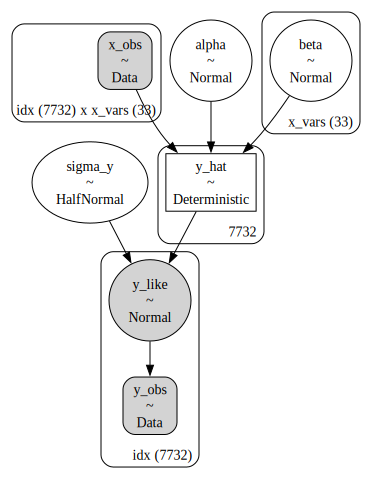

In [42]:
# Visualize the model graphically
pm.model_to_graphviz(bii_pooled)

In [24]:
# Sampler settings
sampler_settings = {
    "draws": 10000,
    "tune": 10000,
    "cores": 4,
    "chains": 4,
    "target_accept": 0.95,
    "nuts_sampler": "numpyro",  # [“pymc”, “nutpie”, “blackjax”, “numpyro”]
}

# Run sampling
bii_pooled_trace = run_sampling(bii_pooled, sampler_settings)

# Compute and print summary diagnostics
summarize_sampling_statistics(bii_pooled_trace)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

There are 0 divergences in the sampling chains.
The mean acceptance rate was 0.988
R-hat for alpha are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for beta are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for sigma_y are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for y_hat are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
ESS for alpha are: 21323 (mean) | 21323 (min) | 21323 (max)
ESS for beta are: 37787 (mean) | 21998 (min) | 58786 (max)
ESS for sigma_y are: 68104 (mean) | 68104 (min) | 68104 (max)
ESS for y_hat are: 48947 (mean) | 17099 (min) | 69510 (max)


In [27]:
# Make model predictions
bii_pooled_predictions = {}
for mode in ["conditional", "conditional_oos", "marginal"]:
    model = bii_pooled_pred(model_data, bii_pooled_trace, mode)
    with model:
        pred_data = pm.sample_posterior_predictive(
            bii_pooled_trace,
            var_names=["y_pred", "y_hat_pred"],
            predictions=True,
        )
        y_pred = pred_data.predictions["y_pred"].mean(dim=["chain"]).values
        y_hat_pred = pred_data.predictions["y_hat_pred"].mean(dim=["chain"]).values
        bii_pooled_predictions[mode] = [y_pred, y_hat_pred]

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

In [28]:
# Calculate R^2 scores
pred_cond = bii_pooled_predictions["conditional"][1]
pred_cond_oos = bii_pooled_predictions["conditional_oos"][1]
pred_marg = bii_pooled_predictions["marginal"][1]
trace = bii_pooled_trace

cond_r2_values, cond_oos_r2_values, marg_r2_values = bayesian_r2(
    pred_cond, pred_cond_oos, pred_marg, trace
)

bii_pooled_r2 = {
    "conditional": cond_r2_values,
    "conditional_oos": cond_oos_r2_values,
    "marginal": marg_r2_values,
}

### Study random intercept model

In [47]:
def bii_abund_study_intercept(model_data) -> pm.Model:
    """Docstring."""

    # Unpack the required model data from dictionary
    coords = model_data["coords"]
    y = model_data["y"]
    x = model_data["x"]
    study_idx = model_data["study_idx"]

    with pm.Model(coords=coords) as model:
        # Observed data variables
        y_obs = pm.Data("y_obs", y, dims="idx")
        x_obs = pm.Data("x_obs", x, dims=("idx", "x_vars"))

        # Hyperpriors for study-level intercept terms
        mu_a = pm.Normal("mu_a", mu=0.5, sigma=0.25)
        sigma_a = pm.HalfNormal("sigma_a", sigma=0.25)

        # Study-level intercept priors (non-centered parameterization)
        study_offset = pm.Normal("study_offset", mu=0, sigma=1, dims="studies")
        alpha_study = pm.Deterministic("alpha_study", mu_a + study_offset * sigma_a)

        # Population level fixed effects priors for slope parameters
        beta = pm.Normal("beta", mu=0, sigma=0.1, dims="x_vars")

        # Variance assumed independent within and between studies
        sigma_y = pm.HalfNormal("sigma_y", sigma=0.25)

        # Expected values
        y_hat = pm.Deterministic(
            "y_hat", alpha_study[study_idx] + pm.math.dot(x_obs, beta)
        )

        # Likelihood function
        y_like = pm.Normal(  # noqa: F841
            "y_like", mu=y_hat, sigma=sigma_y, observed=y_obs, dims="idx"
        )

    return model

In [48]:
def bii_abund_study_intercept_pred(pred_data, trace, mode) -> pm.Model:
    # Unpack data used for predictions
    coords = pred_data["coords"]
    x = pred_data["x"]
    study_idx = pred_data["study_idx"]

    with pm.Model(coords=coords) as pred_model:
        assert mode in [
            "conditional",
            "conditional_oos",
            "marginal",
        ], "mode should be one of ['conditional', 'conditional_oos', 'marginal']"

        # New data points
        x_pred = pm.Data("x_pred", x, dims=("idx", "x_vars"))

        # Parameters where the posterior is taken from the fitted model
        # pm.Flat is a placeholder to indicate that no new prior is specified
        mu_a = pm.Flat("mu_a")
        alpha_study = pm.Flat("alpha_study", dims="studies")
        beta = pm.Flat("beta", dims="x_vars")
        sigma_y = pm.Flat("sigma_y")

        if mode == "conditional":
            y_hat_pred = pm.Deterministic(
                "y_hat_pred", alpha_study[study_idx] + pm.math.dot(x_pred, beta)
            )
        elif mode == "conditional_oos" or mode == "marginal":
            y_hat_pred = pm.Deterministic("y_hat_pred", mu_a + pm.math.dot(x_pred, beta))

        y_pred = pm.Normal(  # noqa: F841
            "y_pred", mu=y_hat_pred, sigma=sigma_y, dims="idx"
        )

    return pred_model

In [49]:
# Instantiate model object
bii_abund_study_intercept = bii_abund_study_intercept(model_data)

# Forward sampling for prior predictive checks
with bii_abund_study_intercept:
    bii_abund_study_intercept_prior = pm.sample_prior_predictive(1000)

Sampling: [beta, mu_a, sigma_a, sigma_y, study_offset, y_like]


In [ ]:
# Visualize the model graphically
pm.model_to_graphviz(bii_abund_study_intercept)

In [73]:
# Sampler settings
sampler_settings = {
    "draws": 2000,
    "tune": 2000,
    "cores": 4,
    "chains": 4,
    "target_accept": 0.95,
    "nuts_sampler": "numpyro",
}

# Run sampling
bii_abund_study_intercept_trace = run_sampling(
    bii_abund_study_intercept, sampler_settings
)

# Compute and print summary diagnostics
summarize_sampling_statistics(bii_abund_study_intercept_trace)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

There are 0 divergences in the sampling chains.
The mean acceptance rate was 0.958
R-hat for alpha_study are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for beta are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for mu_a are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for sigma_a are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for sigma_y are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
R-hat for study_offset are: 1.000 (mean) | 1.000 (min) | 1.010 (max)
R-hat for y_hat are: 1.000 (mean) | 1.000 (min) | 1.000 (max)
ESS for alpha_study are: 11161 (mean) | 1420 (min) | 21473 (max)
ESS for beta are: 7008 (mean) | 1126 (min) | 9927 (max)
ESS for mu_a are: 1007 (mean) | 1007 (min) | 1007 (max)
ESS for sigma_a are: 1027 (mean) | 1027 (min) | 1027 (max)
ESS for sigma_y are: 16774 (mean) | 16774 (min) | 16774 (max)
ESS for study_offset are: 8210 (mean) | 1098 (min) | 21025 (max)
ESS for y_hat are: 13488 (mean) | 6174 (min) | 23476 (max)


In [75]:
bii_abund_study_intercept_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [51]:
# Make model predictions
bii_abund_study_intercept_predictions = {}
for mode in ["conditional", "conditional_oos", "marginal"]:
    model = bii_abund_study_intercept_pred(
        model_data, bii_abund_study_intercept_trace, mode
    )
    with model:
        pred_data = pm.sample_posterior_predictive(
            bii_abund_study_intercept_trace,
            var_names=["y_pred", "y_hat_pred"],
            predictions=True,
        )
        y_pred = pred_data.predictions["y_pred"].mean(dim=["chain"]).values
        y_hat_pred = pred_data.predictions["y_hat_pred"].mean(dim=["chain"]).values
        bii_abund_study_intercept_predictions[mode] = [y_pred, y_hat_pred]

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

In [52]:
# Calculate R^2 scores
pred_cond = bii_abund_study_intercept_predictions["conditional"][1]
pred_cond_oos = bii_abund_study_intercept_predictions["conditional_oos"][1]
pred_marg = bii_abund_study_intercept_predictions["marginal"][1]
trace = bii_abund_study_intercept_trace

cond_r2_values, cond_oos_r2_values, marg_r2_values = bayesian_r2(
    pred_cond, pred_cond_oos, pred_marg, trace
)

bii_abund_study_intercept_r2 = {
    "conditional": cond_r2_values,
    "conditional_oos": cond_oos_r2_values,
    "marginal": marg_r2_values,
}

### Study and block random intercept model

In [ ]:
def bii_abund_study_block_intercept(model_data) -> pm.Model:
    """Docstring."""

    # Unpack the required model data from dictionary
    coords = model_data["coords"]
    y = model_data["y"]
    x = model_data["x"]
    block_idx = model_data["block_idx"]
    block_to_study_idx = model_data["block_to_study_idx"]

    with pm.Model(coords=coords) as model:
        y_obs = pm.Data("y_obs", y, dims="idx")
        x_obs = pm.Data("x_obs", x, dims=("idx", "x_vars"))

        # Hyperpriors for study-level intercept terms
        mu_a = pm.Normal("mu_a", mu=0.5, sigma=0.25)
        sigma_a = pm.HalfNormal("sigma_a", sigma=0.25)

        # Study-level intercept priors (non-centered parameterization)
        study_offset = pm.Normal("study_offset", mu=0, sigma=1, dims="studies")
        alpha_study = pm.Deterministic("alpha_study", mu_a + study_offset * sigma_a)

        # Block-level intercepts, sampled from the corresponding studies
        mu_block = pm.Deterministic("mu_block", var=alpha_study[block_to_study_idx])
        block_offset = pm.Normal("block_offset", mu=0, sigma=1, dims="blocks")
        sigma_block = pm.HalfNormal("sigma_block", sigma=0.25)
        alpha_block = pm.Deterministic(
            "alpha_block", mu_block + block_offset * sigma_block
        )

        # Population level fixed effects priors for slope parameters
        beta = pm.Normal("beta", mu=0, sigma=0.1, dims="x_vars")

        # Variance assumed independent within and between studies and blocks
        sigma_y = pm.HalfNormal("sigma_y", sigma=0.25)

        # Expected values
        y_hat = pm.Deterministic(
            "y_hat", var=alpha_block[block_idx] + pm.math.dot(x_obs, beta)
        )

        # Likelihood function
        y_like = pm.Normal(  # noqa: F841
            "y_like", mu=y_hat, sigma=sigma_y, observed=y_obs, dims="idx"
        )

        return model

In [ ]:
def bii_abund_study_block_intercept_pred(pred_data, trace, mode) -> pm.Model:
    # Unpack data used for predictions
    coords = pred_data["coords"]
    x = pred_data["x"]
    block_idx = pred_data["block_idx"]

    with pm.Model(coords=coords) as pred_model:
        assert mode in [
            "conditional",
            "conditional_oos",
            "marginal",
        ], "mode should be one of ['conditional', 'conditional_oos', 'marginal']"

        # Parameters where the posterior is taken from the fitted model
        # pm.Flat is a placeholder to indicate that no new prior is specified
        mu_a = pm.Flat("mu_a")
        alpha_block = pm.Flat("alpha_block", dims="blocks")
        beta = pm.Flat("beta", dims="x_vars")
        sigma_y = pm.Flat("sigma_y")

        if mode == "conditional":
            y_hat_pred = pm.Deterministic(
                "y_hat_pred", alpha_block[block_idx] + pm.math.dot(x, beta)
            )
        elif mode == "conditional_oos" or mode == "marginal":
            y_hat_pred = pm.Deterministic("y_hat_pred", mu_a + pm.math.dot(x, beta))

        y_pred = pm.Normal(  # noqa: F841
            "y_pred", mu=y_hat_pred, sigma=sigma_y, dims="idx"
        )

    return pred_model

In [ ]:
# Instantiate model object
bii_abund_study_block_intercept = bii_abund_study_block_intercept(model_data)

# Forward sampling for prior predictive checks
with bii_abund_study_intercept:
    bii_abund_study_intercept_prior = pm.sample_prior_predictive(1000)

In [ ]:
# Visualize the model graphically
pm.model_to_graphviz(bii_abund_study_block_intercept)

In [ ]:
# Sampler settings
sampler_settings = {
    "draws": 1000,
    "tune": 1000,
    "cores": 4,
    "chains": 4,
    "target_accept": 0.99,
    "nuts_sampler": "numpyro",
}

# Run sampling
bii_abund_study_block_intercept_trace = run_sampling(
    bii_abund_study_block_intercept, sampler_settings
)

# Compute and print summary diagnostics
summarize_sampling_statistics(bii_abund_study_block_intercept_trace)

In [ ]:
# Make model predictions
bii_abund_study_block_intercept_predictions = {}
for mode in ["conditional", "conditional_oos", "marginal"]:
    model = bii_abund_study_block_intercept_pred(
        model_data, bii_abund_study_block_intercept_trace, mode
    )
    with model:
        pred_data = pm.sample_posterior_predictive(
            bii_abund_study_block_intercept_trace,
            var_names=["y_pred", "y_hat_pred"],
            predictions=True,
        )
        y_pred = pred_data.predictions["y_pred"].mean(dim=["chain"]).values
        y_hat_pred = pred_data.predictions["y_hat_pred"].mean(dim=["chain"]).values
        bii_abund_study_block_intercept_predictions[mode] = [y_pred, y_hat_pred]

In [ ]:
# Calculate R^2 scores
pred_cond = bii_abund_study_block_intercept_predictions["conditional"][1]
pred_cond_oos = bii_abund_study_block_intercept_predictions["conditional_oos"][1]
pred_marg = bii_abund_study_block_intercept_predictions["marginal"][1]
trace = bii_abund_study_block_intercept_trace

cond_r2_values, cond_oos_r2_values, marg_r2_values = bayesian_r2(
    pred_cond, pred_cond_oos, pred_marg, trace
)

bii_abund_study_block_intercept_r2 = {
    "conditional": cond_r2_values,
    "conditional_oos": cond_oos_r2_values,
    "marginal": marg_r2_values,
}

### Study random slope model

In [ ]:
def bii_abund_study_slope(model_data) -> pm.Model:
    """Docstring."""

    # Unpack the required model data from dictionary
    coords = model_data["coords"]
    y = model_data["y"]
    z_study = model_data["z_study"]
    x_z_study_diff = model_data["x_z_study_diff"]
    study_idx = model_data["study_idx"]

    with pm.Model(coords=coords) as model:

        # Observed data that be changed later on for train-test runs
        y_obs = pm.MutableData("y_obs", value=y, dims="idx")
        z_study = pm.MutableData("z_study", value=z_study, dims=("idx", "z_study_vars"))
        x_res = pm.MutableData(
            "x_res", value=x_z_study_diff, dims=("idx", "z_study_diff_vars")
        )

        # Hyperpriors for study-level intercept terms
        mu_a = pm.Normal("mu_a", mu=0.5, sigma=0.25)
        sigma_a = pm.HalfNormal("sigma_a", sigma=0.25)

        # Hyperpriors for the slope terms
        mu_b_study = pm.Normal("mu_b_study", mu=0, sigma=0.25, dims="z_study_vars")
        sigma_b_study = pm.HalfNormal("sigma_b_study", sigma=0.25, dims="z_study_vars")

        # Study-level priors (non-centered parameterization)
        study_offset_1 = pm.Normal("study_offset_1", mu=0, sigma=1, dims="studies")
        study_offset_2 = pm.Normal(
            "study_offset_2", mu=0, sigma=1, dims=("studies", "z_study_vars")
        )
        alpha_study = pm.Deterministic("alpha_study", mu_a + study_offset_1 * sigma_a)
        beta_study = pm.Deterministic(
            "beta_study", mu_b_study + study_offset_2 * sigma_b_study
        )

        # Priors for parameters that only apply at the population level
        beta = pm.Normal("beta", mu=0, sigma=0.25, dims="x_z_study_diff_vars")

        # Variance assumed independent within and between studies
        sigma_y = pm.HalfNormal("sigma_y", sigma=0.25)

        # Expected values
        y_hat = pm.Deterministic(
            "y_hat",
            var=alpha_study[study_idx]
            + pm.math.sum(z_study * beta_study[study_idx], axis=1)
            + pm.math.dot(x_res, beta),
        )

        # Likelihood function
        y_like = pm.Normal(  # noqa: F841
            "y_like", mu=y_hat, sigma=sigma_y, observed=y_obs, dims="idx"
        )

        return model

In [ ]:
# Instantiate model object
bii_abund_study_slope = bii_abund_study_slope(model_data)

In [ ]:
# Visualize the model graphically
pm.model_to_graphviz(bii_abund_study_slope)

In [ ]:
# Forward sampling for prior predictive checks
with bii_abund_study_slope:
    bii_abund_study_slope_prior = pm.sample_prior_predictive(1000)

In [ ]:
# Sampler settings
sampler_settings = {
    "draws": 1000,
    "tune": 1000,
    "cores": 4,
    "chains": 4,
    "target_accept": 0.99,
    "nuts_sampler": "numpyro",
}

# Run sampling
bii_abund_study_slope_trace = run_sampling(bii_abund_study_slope, sampler_settings)

# Compute and print summary diagnostics
summarize_sampling_statistics(bii_abund_study_slope_trace)

In [ ]:
# Set data for in-sample predictions
with bii_abund_study_slope:
    pm.set_data(
        {
            "y_obs": model_data["y"],
            "z_study": model_data["z_study"],
            "x_res": model_data["x_z_study_diff"],
        },
        coords={"idx": model_data["coords"]["idx"]},
    )

    # Sample posterior predictive distribution
    bii_abund_study_slope_trace.extend(
        pm.sample_posterior_predictive(bii_abund_study_slope_trace, predictions=False)
    )

    # Compute log likelihood for LOO and WAIC
    pm.compute_log_likelihood(bii_abund_study_slope_trace)

### Study and block random slope model

In [ ]:
def bii_abund_study_block_slope(model_data) -> pm.Model:
    """Docstring."""

    # Unpack the required model data from dictionary
    coords = model_data["coords"]
    y = model_data["y"]
    z_block = model_data["z_block"]
    x_z_block_diff = model_data["x_z_block_diff"]
    block_idx = model_data["block_idx"]
    block_to_study_idx = model_data["block_to_study_idx"]

    with pm.Model(coords=coords) as model:

        # Observed data that be changed later on for train-test runs
        y_obs = pm.MutableData("y_obs", value=y, dims="idx")
        z_block = pm.MutableData("z_block", value=z_block, dims=("idx", "z_block_vars"))
        x_res = pm.MutableData(
            "x_res", value=x_z_block_diff, dims=("idx", "z_block_diff_vars")
        )

        # Hyperpriors for study-level intercept terms
        mu_a = pm.Normal("mu_a", mu=0.5, sigma=0.25)
        sigma_a = pm.HalfNormal("sigma_a", sigma=0.25)

        mu_b_study = pm.Normal("mu_b_study", mu=0, sigma=0.25, dims="z_study_vars")
        sigma_b_study = pm.HalfNormal("sigma_b_study", sigma=0.25, dims="z_study_vars")

        # Study-level priors (non-centered parameterization)
        study_offset_1 = pm.Normal("study_offset_1", mu=0, sigma=1, dims="studies")
        study_offset_2 = pm.Normal(
            "study_offset_2", mu=0, sigma=1, dims=("studies", "z_study_vars")
        )
        alpha_study = pm.Deterministic("alpha_study", mu_a + study_offset_1 * sigma_a)
        beta_study = pm.Deterministic(
            "beta_study", mu_b_study + study_offset_2 * sigma_b_study
        )

        # Block-level intercepts, sampled from the corresponding studies
        mu_a_block = pm.Deterministic("mu_a_block", var=alpha_study[block_to_study_idx])
        mu_b_block = pm.Deterministic("mu_b_block", var=beta_study[block_to_study_idx])
        block_offset_1 = pm.Normal("block_offset_1", mu=0, sigma=1, dims="blocks")
        block_offset_2 = pm.Normal(
            "block_offset_2", mu=0, sigma=1, dims=("blocks", "z_block_vars")
        )
        sigma_block = pm.HalfNormal("sigma_block", sigma=0.25)
        alpha_block = pm.Deterministic(
            "alpha_block", mu_a_block + block_offset_1 * sigma_block
        )
        beta_block = pm.Deterministic(
            "beta_block", mu_b_block + block_offset_2 * sigma_block
        )

        # Prior for parameters that only apply at the population level
        beta = pm.Normal("beta", mu=0, sigma=0.25, dims="x_z_block_diff_vars")

        # Variance assumed independent within and between studies
        sigma_y = pm.HalfNormal("sigma_y", sigma=0.25)

        # Expected values
        y_hat = pm.Deterministic(
            "y_hat",
            var=alpha_block[block_idx]
            + pm.math.sum(z_block * beta_block[block_idx], axis=1)
            + pm.math.dot(x_res, beta),
        )

        # Likelihood function
        y_like = pm.Normal(  # noqa: F841
            "y_like", mu=y_hat, sigma=sigma_y, observed=y_obs, dims="idx"
        )

        return model

In [ ]:
# Instantiate model object
bii_abund_study_block_slope = bii_abund_study_block_slope(model_data)

In [ ]:
# Visualize the model graphically
pm.model_to_graphviz(bii_abund_study_block_slope)

In [ ]:
# Forward sampling for prior predictive checks
with bii_abund_study_block_slope:
    bii_abund_study_block_slope_prior = pm.sample_prior_predictive(1000)

In [ ]:
# Sampler settings
sampler_settings = {
    "draws": 1000,
    "tune": 1000,
    "cores": 4,
    "chains": 4,
    "target_accept": 0.99,
    "nuts_sampler": "numpyro",
}

# Run sampling
bii_abund_study_block_slope_trace = run_sampling(
    bii_abund_study_block_slope, sampler_settings
)

# Compute and print summary diagnostics
summarize_sampling_statistics(bii_abund_study_block_slope_trace)

In [ ]:
# Set data for in-sample predictions
with bii_abund_study_block_slope:
    pm.set_data(
        {
            "y_obs": model_data["y"],
            "z_block": model_data["z_block"],
            "x_res": model_data["x_z_study_diff"],
        },
        coords={"idx": model_data["coords"]["idx"]},
    )

    # Sample posterior predictive distribution
    bii_abund_study_block_slope_trace.extend(
        pm.sample_posterior_predictive(
            bii_abund_study_block_slope_trace, predictions=False
        )
    )

    # Compute log likelihood for LOO and WAIC
    pm.compute_log_likelihood(bii_abund_study_block_slope_trace)

## High-level multiple model comparison

### LOO cross validation and WAIC

In [29]:
trace_dict = {
    "bii_pooled": bii_pooled_trace,
    #"bii_abund_study_intercept": bii_abund_study_intercept_trace,
    #"bii_abund_study_block_intercept": bii_abund_study_block_intercept_trace,
    #"bii_abund_study_slope": bii_abund_study_slope_trace,
    #"bii_abund_study_block_slope": bii_abund_study_block_slope_trace,
}
df_comp = az.compare(trace_dict)
df_comp

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
az.plot_compare(df_comp, insample_dev=True);

### R^2 score comparison

In [53]:
pred_dict = {
    "bii_pooled": bii_pooled_r2,
    "bii_abund_study_intercept": bii_abund_study_intercept_r2,
    #"bii_abund_study_block_intercept": bii_abund_study_block_intercept_r2,
    # "bii_abund_study_slope": bii_abund_study_slope_r2,
    # "bii_abund_study_block_slope": bii_abund_study_block_slope_r2,
}

print("Comparison of R^2 values for different models \n")
for model in pred_dict.keys():
    print(f"{model}:")
    for mode in pred_dict[model].keys():
        r2 = pred_dict[model][mode]
        mean, std = np.mean(r2), np.std(r2)
        print(f"{mode}: {mean:.3f} (mean) | {std:.3f} (std)")
    print("\n")

Comparison of R^2 values for different models 

bii_pooled:
conditional: 0.077 (mean) | 0.003 (std)
conditional_oos: 0.077 (mean) | 0.003 (std)
marginal: 0.077 (mean) | 0.003 (std)


bii_abund_study_intercept:
conditional: 0.479 (mean) | 0.004 (std)
conditional_oos: 0.051 (mean) | 0.006 (std)
marginal: 0.051 (mean) | 0.006 (std)




## Prior predictive checks

In [54]:
# Selecting prior samples

# bii_pooled_prior
# bii_abund_study_intercept_prior
# bii_abund_study_block_intercept_prior
# bii_abund_study_slope_prior
# bii_abund_study_block_slope_prior

prior_samples = bii_abund_study_intercept_prior

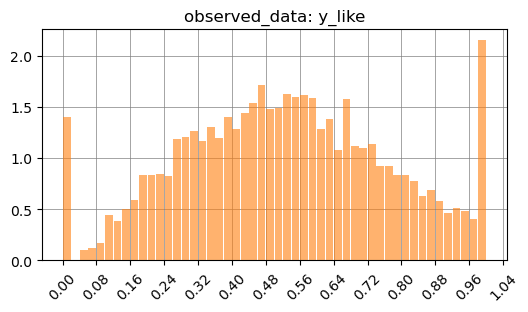

In [55]:
plot_prior_distribution(prior_samples, category="observed_data", variable="y_like")

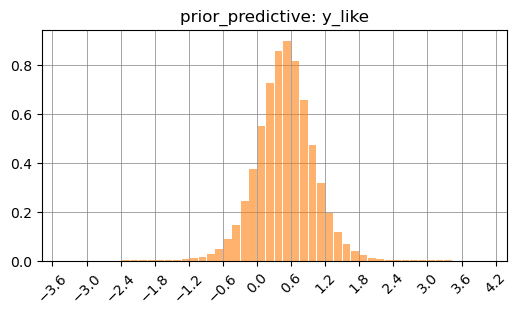

In [56]:
plot_prior_distribution(prior_samples, category="prior_predictive", variable="y_like")

## Model output summary

In [57]:
# Update the right trace object here

# bii_abund_study_intercept_trace
# bii_abund_study_block_intercept_trace
# bii_abund_study_slope_trace
# bii_abund_study_block_slope_trace

trace = bii_abund_study_intercept_trace

In [59]:
# Summary output for posteror of hyperprior
az.summary(trace, var_names=["mu_a", "beta"], round_to=2)

mean    sd  hdi_3%  \
mu_a                                                0.67  0.01    0.65   
beta[Primary vegetation_Light use]                 -0.02  0.01   -0.04   
beta[Primary vegetation_Intense use]               -0.05  0.02   -0.09   
beta[Secondary vegetation_Minimal use]             -0.02  0.01   -0.04   
beta[Secondary vegetation_Light use]               -0.03  0.01   -0.04   
beta[Secondary vegetation_Intense use]             -0.10  0.01   -0.11   
beta[Cropland_Minimal use]                          0.01  0.02   -0.02   
beta[Cropland_Light_Intense]                       -0.12  0.03   -0.18   
beta[Pasture_Minimal use]                          -0.02  0.02   -0.06   
beta[Pasture_Light_Intense]                        -0.11  0.02   -0.14   
beta[Urban_All uses]                                0.03  0.03   -0.03   
beta[Pop_density_1km_log]                          -0.03  0.01   -0.04   
beta[Road_density_50km_cbrt]                        0.02  0.01   -0.00   
beta[Mean_pop_density_1km_log]                     -0.01  0.01   -0.03   
beta[Primary vegetation_Light use x Pop_density...  0.02  0.01    0.00   
beta[Primary vegetation_Intense use x Pop_densi...  0.02  0.02   -0.01   
beta[Secondary vegetation_Minimal use x Pop_den... -0.01  0.01   -0.02   
beta[Secondary vegetation_Light use x Pop_densi...  0.01  0.01   -0.00   
beta[Secondary vegetation_Intense use x Pop_den...  0.04  0.01    0.02   
beta[Cropland_Minimal use x Pop_density_1km_log]    0.02  0.02   -0.02   
beta[Cropland_Light_Intense x Pop_density_1km_log]  0.03  0.03   -0.03   
beta[Pasture_Minimal use x Pop_density_1km_log]     0.05  0.02    0.02   
beta[Pasture_Light_Intense x Pop_density_1km_log]   0.02  0.02   -0.02   
beta[Urban_All uses x Pop_density_1km_log]         -0.03  0.02   -0.07   
beta[Primary vegetation_Light use x Road_densit... -0.03  0.01   -0.05   
beta[Primary vegetation_Intense use x Road_dens...  0.06  0.02    0.02   
beta[Secondary vegetation_Minimal use x Road_de... -0.01  0.01   -0.03   
beta[Secondary vegetation_Light use x Road_dens... -0.03  0.01   -0.04   
beta[Secondary vegetation_Intense use x Road_de... -0.04  0.01   -0.06   
beta[Cropland_Minimal use x Road_density_50km_c... -0.02  0.02   -0.05   
beta[Cropland_Light_Intense x Road_density_50km... -0.09  0.02   -0.13   
beta[Pasture_Minimal use x Road_density_50km_cbrt]  0.01  0.03   -0.05   
beta[Pasture_Light_Intense x Road_density_50km_... -0.06  0.02   -0.10   
beta[Urban_All uses x Road_density_50km_cbrt]       0.05  0.03   -0.01   

                                                    hdi_97%  mcse_mean  \
mu_a                                                   0.70        0.0   
beta[Primary vegetation_Light use]                    -0.00        0.0   
beta[Primary vegetation_Intense use]                  -0.03        0.0   
beta[Secondary vegetation_Minimal use]                -0.01        0.0   
beta[Secondary vegetation_Light use]                  -0.01        0.0   
beta[Secondary vegetation_Intense use]                -0.08        0.0   
beta[Cropland_Minimal use]                             0.04        0.0   
beta[Cropland_Light_Intense]                          -0.07        0.0   
beta[Pasture_Minimal use]                              0.01        0.0   
beta[Pasture_Light_Intense]                           -0.07        0.0   
beta[Urban_All uses]                                   0.09        0.0   
beta[Pop_density_1km_log]                             -0.01        0.0   
beta[Road_density_50km_cbrt]                           0.04        0.0   
beta[Mean_pop_density_1km_log]                         0.02        0.0   
beta[Primary vegetation_Light use x Pop_density...     0.04        0.0   
beta[Primary vegetation_Intense use x Pop_densi...     0.05        0.0   
beta[Secondary vegetation_Minimal use x Pop_den...     0.01        0.0   
beta[Secondary vegetation_Light use x Pop_densi...     0.03        0.0   
beta[Secondary vegetation_Intense use x Pop_den...     

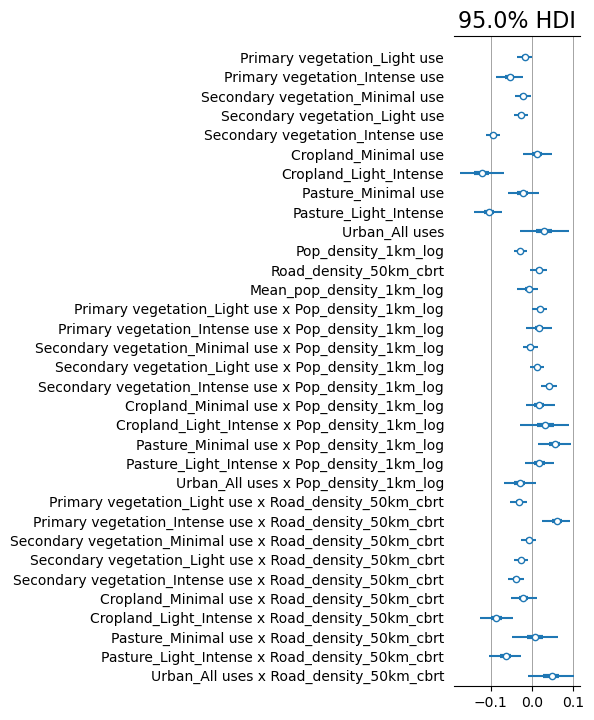

In [63]:
forest_plot(trace, var_names=["beta"])

### Hyperprior posterior distributions

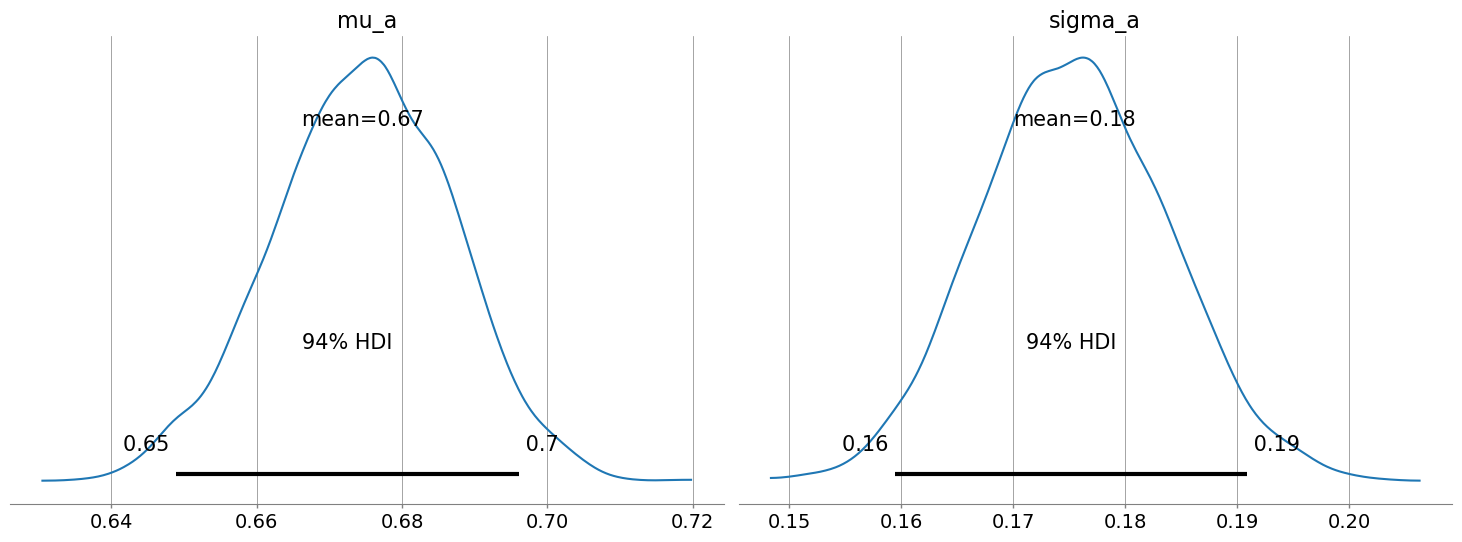

In [64]:
az.plot_posterior(trace, var_names=["mu_a", "sigma_a"])
plt.tight_layout()
plt.show()

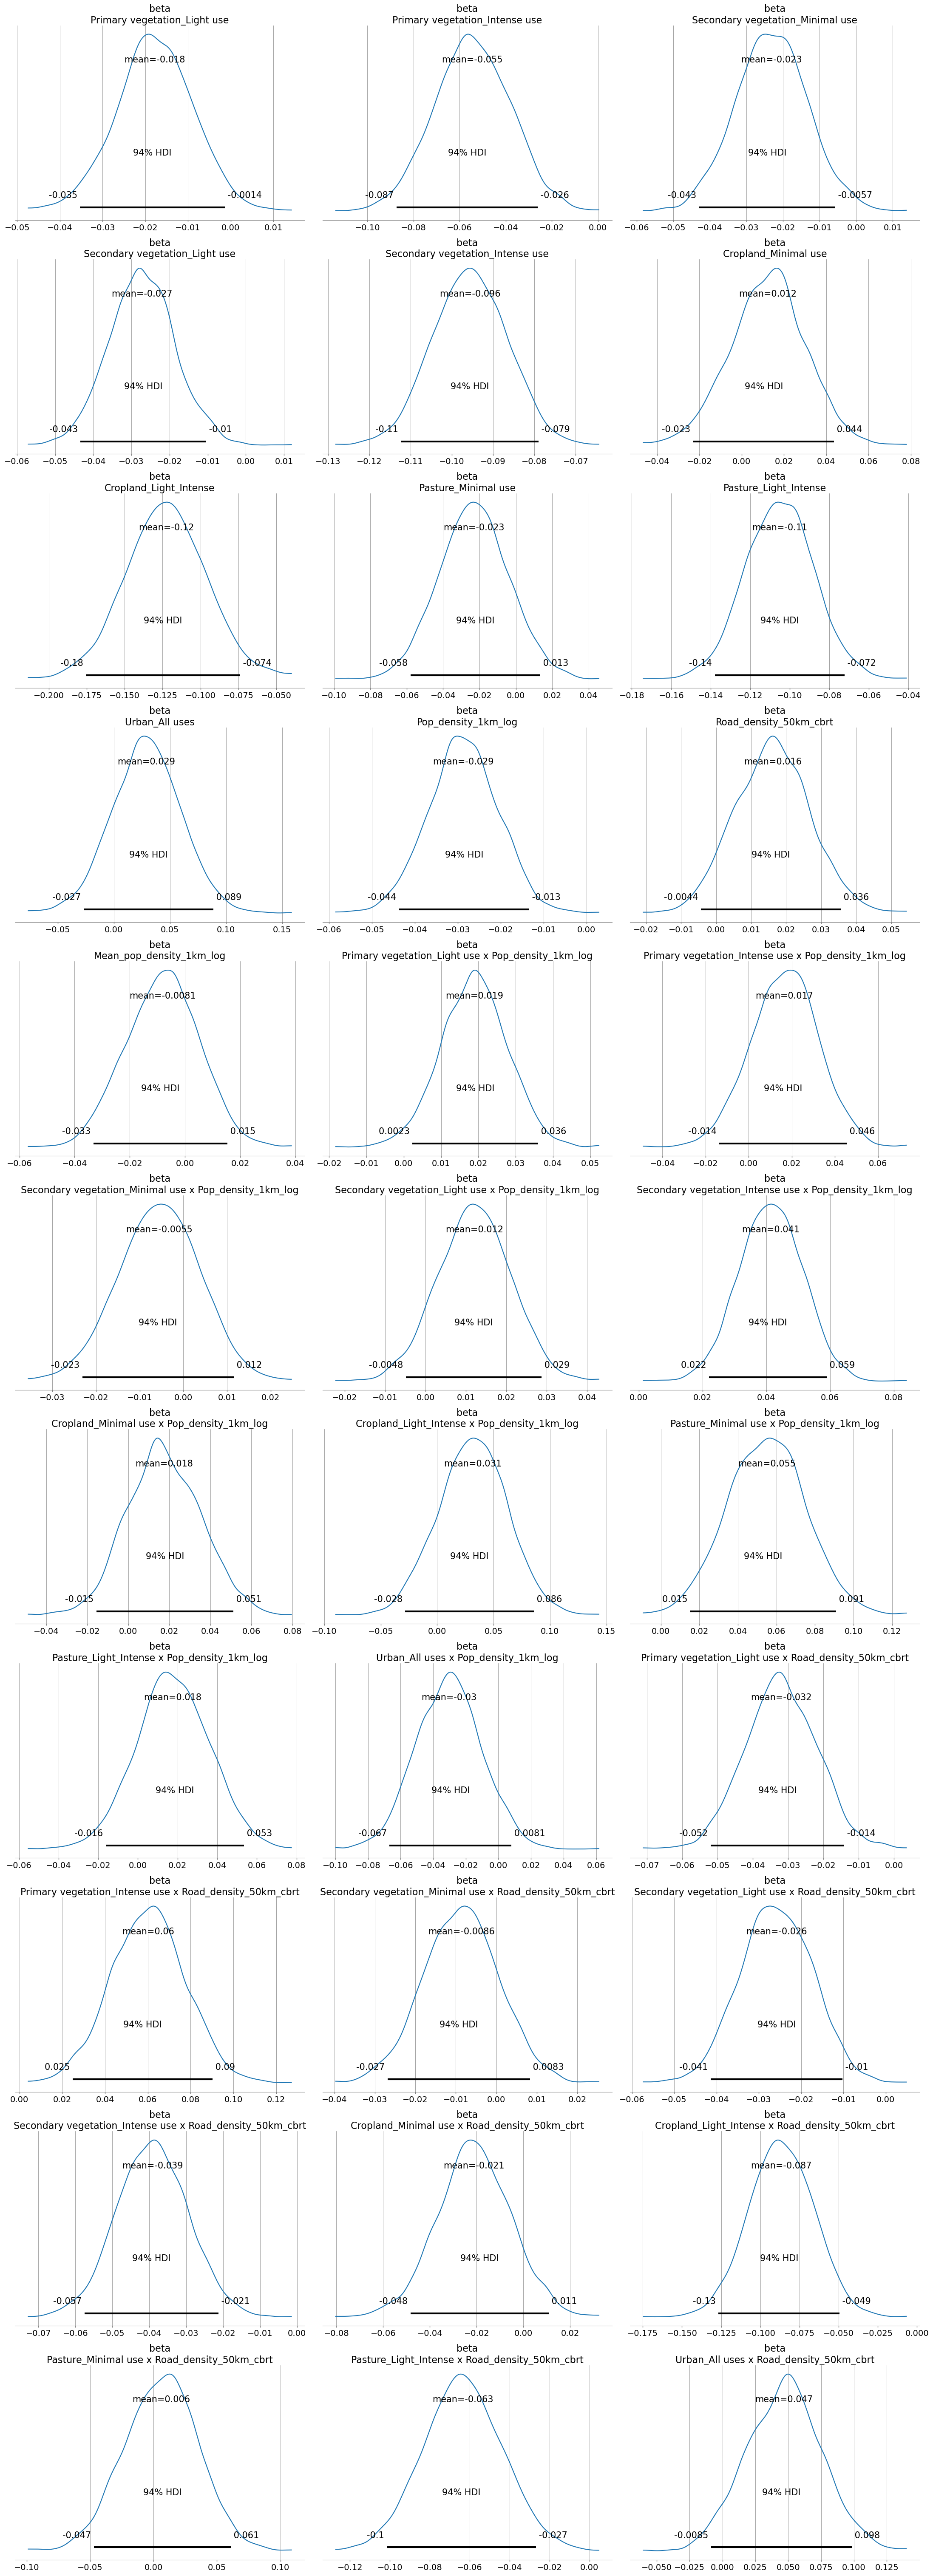

In [66]:
az.plot_posterior(trace, var_names=["beta"])
plt.tight_layout()
plt.show()

## Model fit

### Conditional and marginal R^2 scores

In [67]:
def plot_r2_distribution(r2_values):
    plt.figure(figsize=(8, 4))
    plt.hist(r2_values, bins=30, alpha=0.6, color="g", edgecolor="black")
    mean_r2 = np.mean(r2_values)
    median_r2 = np.median(r2_values)
    plt.axvline(
        mean_r2,
        color="r",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {mean_r2:.2f}",
    )
    plt.axvline(
        median_r2,
        color="b",
        linestyle="dashed",
        linewidth=1,
        label=f"Median: {median_r2:.2f}",
    )
    plt.title("Distribution of Bayesian R² Values")
    plt.xlabel("R²")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

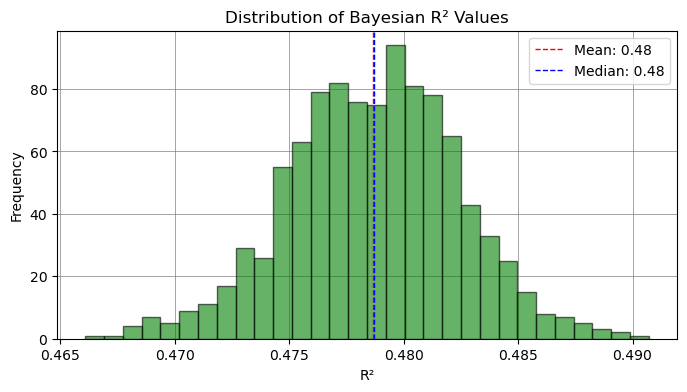

In [69]:
plot_r2_distribution(cond_r2_values)

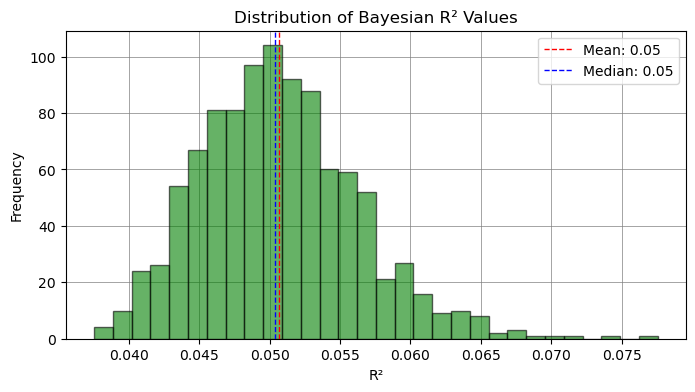

In [70]:
plot_r2_distribution(marg_r2_values)

### Leave-one-out cross validation (PSIS-LOO-CV)

In [ ]:
loo = az.loo(trace, var_name="y_like")
loo

### Widely applicable information criterion (WAIC)

In [ ]:
waic = az.waic(trace, var_name="y_like")
waic

### Prediction and residual plots

In [ ]:
def plot_predictions_and_residuals(y_true: np.array, y_pred: np.array) -> None:

    # Scatter plot of predictions vs actuals
    plt.figure(figsize=(8, 4))
    plt.scatter(y_true, y_pred, alpha=0.2)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "--k", linewidth=1)
    # plt.text(0.05, 0.95, f"R² = {r2:.3f}", fontsize=12, transform=plt.gca().transAxes)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.title("Predictions vs actuals")
    plt.grid(True)
    plt.show()

    # Residuals vs actual scatter plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    plt.scatter(y_true, residuals, alpha=0.2)
    plt.axhline(y=0, color="r", linestyle="--", linewidth=2)
    plt.xlabel("Actual values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs actual values")
    plt.grid(True)
    plt.show()

    # Residual Density Plot (Distribution of Residuals)
    plt.figure(figsize=(8, 4))
    sns.kdeplot(residuals, fill=True)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title("Residual density Plot")
    plt.grid(True)
    plt.show()

In [ ]:
pred_with_re = trace.posterior_predictive["y_like"].mean(dim=["chain", "draw"]).values
y_true = trace.observed_data["y_like"].values

In [ ]:
plot_predictions_and_residuals(y_true, pred_with_re)

## Posterior predictive distribution

In [ ]:
ax = az.plot_ppc(trace)
for label in ax.get_xticklabels():
    label.set_fontsize(10)
plt.xlabel("")
ax.legend(fontsize=10)
plt.show()

In [ ]:
ax = az.plot_ppc(trace, kind="cumulative")
for label in ax.get_xticklabels():
    label.set_fontsize(10)
plt.xlabel("")
ax.legend(fontsize=10)
plt.show()

## Debugging: Posterior predictive checks

### Trace plots

In [71]:
def trace_plot(
    trace,
    var_names,
):
    axes = az.plot_trace(
        data=trace,
        var_names=var_names,
        divergences="bottom",
        compact=False,  # Plot multidimensional variables in one plot
        combined=False,  # Combine chains into a single line
    )

    plt.tight_layout()
    plt.show()

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  warnings.warn(


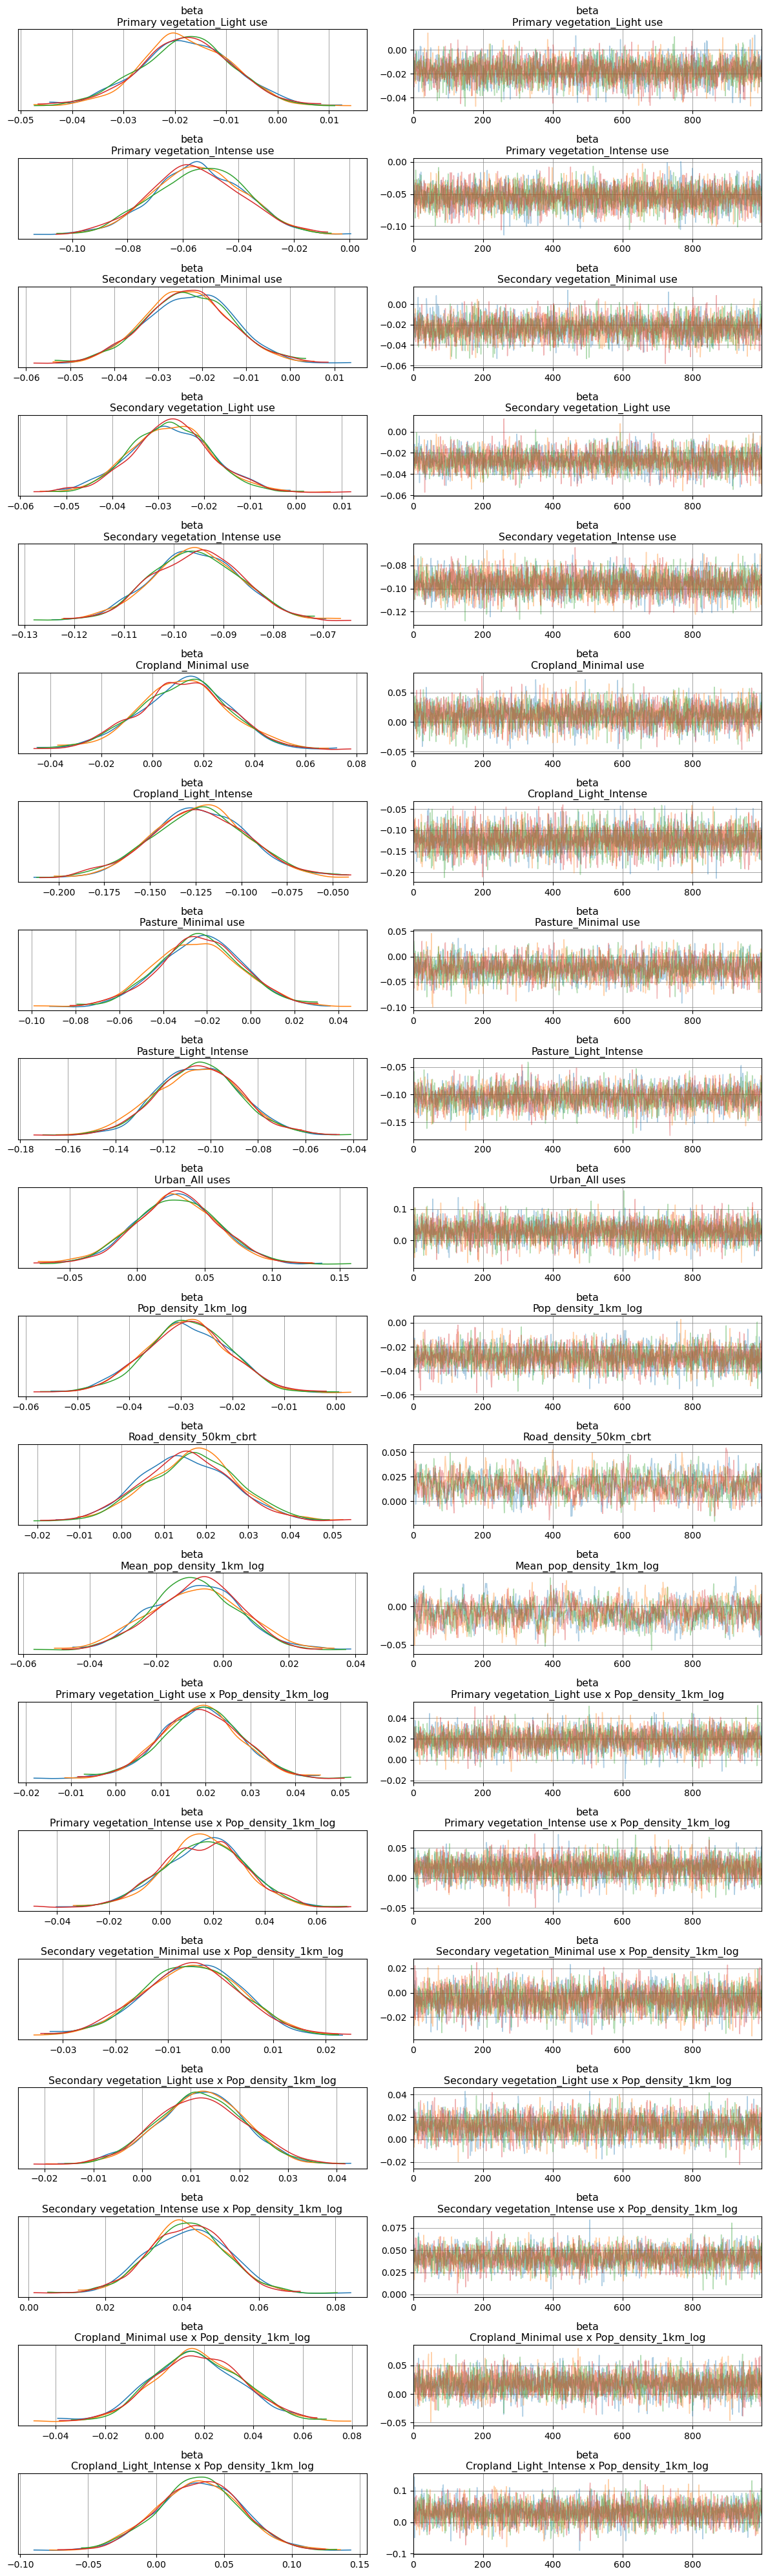

In [74]:
# Posteriors of hyperpriors: mu_beta
trace_plot(trace, var_names=["beta"])

### ESS plots

In [ ]:
# ESS for posterior of hyperparameters
az.plot_ess(trace, kind="evolution", var_names=["beta"])
plt.tight_layout()
plt.show()

### Energy plot

In [ ]:
az.plot_energy(trace)
plt.show()

## Detailed debugging

### Autocorrelation in chains

In [ ]:
az.plot_autocorr(trace, var_names=["beta"])
plt.tight_layout()
plt.show()